Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [23]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

In [24]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [25]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [26]:
CONSTRAINTS

array([[160,  92],
       [129,  86],
       [265, 239]], dtype=int32)

# Solver

In [27]:
ProblemParam = namedtuple("Problem", ["values", "weights", "constraints", "num_knapsacks", "num_items", "num_dimensions"])

# Random local perturbation of a solution.
# - Performs a random flip (add/remove) of a single item in a knapsack.
# - Optionally performs a random swap between two knapsacks.
def modify_solution(solution: np.ndarray, prob: ProblemParam) -> np.ndarray:
    nk = prob.num_knapsacks
    ni = prob.num_items
    k = np.random.randint(0, nk)
    item = np.random.randint(0, ni)
    if solution[k, item]:
        solution[k, item] = False
    elif not np.any(solution[:, item]):
        solution[k, item] = True

    if nk >= 2:
        k1, k2 = np.random.choice(nk, size=2, replace=False)
        i1 = np.random.randint(0, ni)
        i2 = np.random.randint(0, ni)
        solution[k1, i1], solution[k2, i2] = solution[k2, i2], solution[k1, i1]

    return solution

# Feasibility test for a solution.
# - Ensures each item is assigned to at most one knapsack.
# - Ensures each knapsack's weight sums do not exceed its per-dimension constraints.
# - Returns True if solution satisfies both checks, False otherwise.
def check_feasible(solution: np.ndarray, prob: ProblemParam) -> bool:
    if not np.all(solution.sum(axis=0) <= 1):
        return False
    for k in range(prob.num_knapsacks):
        if solution[k].any():
            if np.any(prob.weights[solution[k]].sum(axis=0) > prob.constraints[k]):
                return False
    return True

# Fitness evaluator with penalty for infeasible solutions.
# - If infeasible returns a strong negative penalty.
# - Otherwise returns the total value of all assigned items (as float).
def fitness_score(solution: np.ndarray, prob: ProblemParam) -> float:
    if not check_feasible(solution, prob):
        return -100
    return float(prob.values[np.any(solution, axis=0)].sum())

# Repair operator that modifies a solution until it becomes feasible.
# - Repeatedly removes items or resolves duplicates until all constraints are respected.
def make_feasible(solution: np.ndarray, prob: ProblemParam) -> np.ndarray:
    while not check_feasible(solution, prob):
        k = np.random.randint(0, prob.num_knapsacks)
        items_in_k = np.where(solution[k])[0]
        if items_in_k.size > 0:
            item_to_remove = np.random.choice(items_in_k)
            solution[k, item_to_remove] = False
            continue
        duplicates = np.where(solution.sum(axis=0) > 1)[0]
        if duplicates.size > 0:
            item = np.random.choice(duplicates)
            ks = np.where(solution[:, item])[0]
            kremove = np.random.choice(ks)
            solution[kremove, item] = False
            continue
        k_rand = np.random.randint(0, prob.num_knapsacks)
        items_rand = np.where(solution[k_rand])[0]
        if items_rand.size > 0:
            solution[k_rand, np.random.choice(items_rand)] = False
    return solution

# Simulated-annealing style solver.
# - prob: ProblemParam with instance data.
# - initial_solution: optional starting boolean matrix (knapsacks x items).
# - iteration: number of iterations.
# - temperature: initial temperature for acceptance probability.
# - Returns (best_solution, best_fitness).
def solve_problem(prob: ProblemParam, initial_solution: np.ndarray | None = None,
                  iteration: int = 5000, temperature: float = 100.0):
    nk = prob.num_knapsacks
    ni = prob.num_items

    if initial_solution is None:
        cur_solution = np.zeros((nk, ni), dtype=bool)
    else:
        cur_solution = initial_solution.copy()

    cur_solution = make_feasible(cur_solution, prob)

    best_solution = cur_solution.copy()
    best_fitness = fitness_score(best_solution, prob)
    cur_fitness = fitness_score(cur_solution, prob)
    best_fitness_history = [0] * (iteration + 1)
    cur_fitness_history = [0] * (iteration + 1)

    best_fitness_history[0] = best_fitness
    cur_fitness_history[0] = cur_fitness

    for i in range(iteration):
        if i % 200 == 0:
            temperature *= 0.9
        
        new_solution = modify_solution(cur_solution.copy(), prob)
        new_fit = fitness_score(new_solution, prob)

        delta = new_fit - cur_fitness

        if delta > 0 or np.random.rand() < np.exp(delta / temperature):
            if(new_fit > 0):
                cur_solution = new_solution.copy()
                cur_fitness = new_fit
                if new_fit > best_fitness:
                    best_solution = new_solution.copy()
                    best_fitness = new_fit
        best_fitness_history[i+1] = best_fitness
        cur_fitness_history[i+1] = cur_fitness
    plot_knapsack_history(best_fitness_history, cur_fitness_history)
    print(f"Final best fitness: {best_fitness}")
    return best_solution, best_fitness


def plot_knapsack_history(best_fitness_history, cur_fitness_history) -> None:
    plt.loglog(best_fitness_history, label='Best Fitness')
    plt.loglog(cur_fitness_history, label='Current Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.title('Knapsack Problem Fitness Over Iterations')
    plt.legend()
    plt.show()

## TEST PROBLEMS

In [28]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

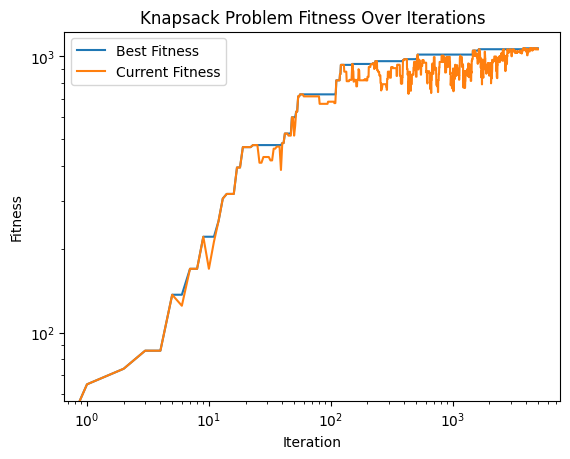

Final best fitness: 1065.0


In [29]:
TEMP = 100.0
params = ProblemParam(
    values=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS,
    num_knapsacks=NUM_KNAPSACKS,        
    num_items=NUM_ITEMS,
    num_dimensions=NUM_DIMENSIONS
)

solution, fit = solve_problem(prob=params, temperature=TEMP)

In [30]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

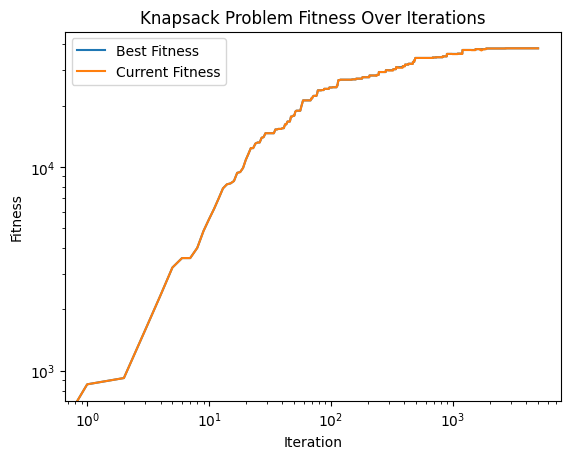

Final best fitness: 38175.0


In [31]:
TEMP = 200.0
params = ProblemParam(
    values=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS,
    num_knapsacks=NUM_KNAPSACKS,        
    num_items=NUM_ITEMS,
    num_dimensions=NUM_DIMENSIONS
)

solution, fit = solve_problem(prob=params, temperature=TEMP)

In [32]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

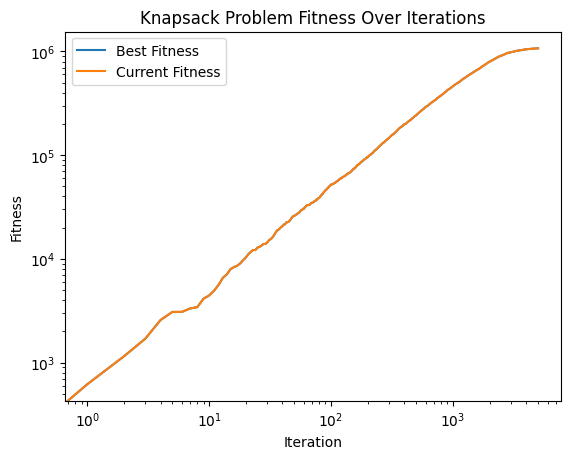

Final best fitness: 1072191.0


In [33]:
TEMP = 300.0
params = ProblemParam(
    values=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS,
    num_knapsacks=NUM_KNAPSACKS,        
    num_items=NUM_ITEMS,
    num_dimensions=NUM_DIMENSIONS
)

solution, fit = solve_problem(prob=params, temperature=TEMP)